# **Library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio
from PIL import Image
import os
import random
import torch
import torch.nn as nn
from google.colab import drive
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, BatchNormalization, ReLU,Conv2DTranspose, Concatenate, MaxPool2D,Input)
from tensorflow.keras import Model
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **EDA**

In [3]:
images_path=os.listdir("/content/drive/MyDrive/satalite data/data/images")
images_path=sorted(images_path,key=lambda x:int(x.split(".")[0]))

In [4]:
labels_path=os.listdir("/content/drive/MyDrive/satalite data/data/labels")
labels_path=sorted(labels_path,key= lambda x:int(x.split('.')[0]))

In [5]:
corrected_labels=[]
for path in labels_path:
  if path.find('_')==-1:
    corrected_labels.append(path)

In [6]:
print(len(labels_path),len(corrected_labels))

456 306


In [7]:
for i in range(len(images_path)):
  images_path[i]=os.path.join("/content/drive/MyDrive/satalite data/data/images",images_path[i])
  corrected_labels[i]=os.path.join("/content/drive/MyDrive/satalite data/data/labels",corrected_labels[i])

## **Images Visulization**

In [8]:
index=random.choice(range(len(images_path)))
img=iio.imread(images_path[index])
img.shape

(128, 128, 12)

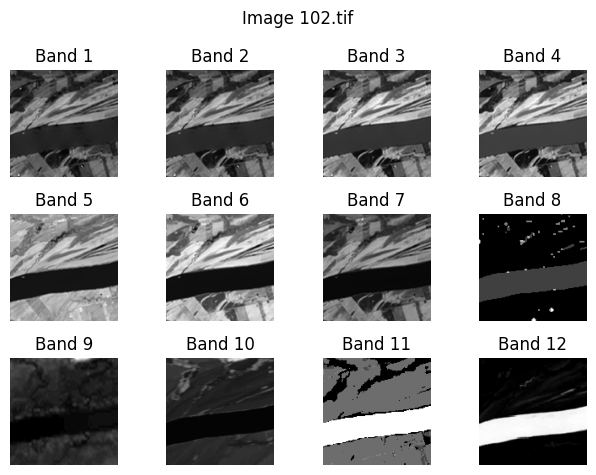

In [9]:
for i in range(img.shape[2]):
  plt.subplot(3,4,i+1)
  plt.imshow(img[:,:,i],cmap='gray')
  plt.axis('off')
  plt.title(f'Band {i+1}')
plt.suptitle(f'Image {os.path.split(images_path[index])[1]}')
plt.tight_layout()
plt.show()


## **Label Visualization**

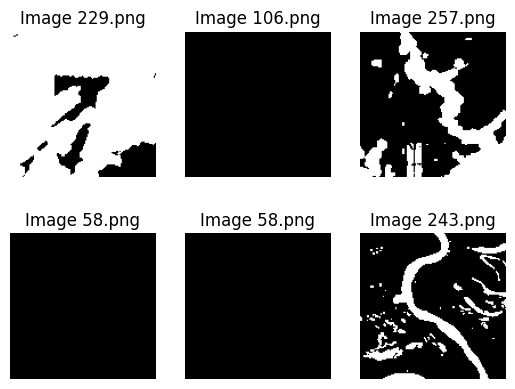

In [10]:
for i in range(0,6):
  index=random.choice(range(len(corrected_labels)))
  label=Image.open(corrected_labels[index]).convert('L')
  label=np.array(label)
  plt.subplot(2,3,i+1)
  plt.imshow(label,cmap='gray')
  plt.axis('off')
  plt.title(f'Image {os.path.split(corrected_labels[index])[1]}')

# **Preprocessing**

## **Scaling**

In [11]:
scaler=MinMaxScaler()

In [12]:
images = []
masks = []
for idx in range(0, len(images_path)):
    # Image
    img = np.array(iio.imread(images_path[idx]),dtype=np.float32)

    print(f"\nImage {idx} - Before scaling:")
    for channel in range(img.shape[-1]):
        channel_data = img[..., channel]
        print(f"Channel {channel}: min={channel_data.min()}, max={channel_data.max()}")
        img[:,:,channel]=(img[:,:,channel]-img[:,:,channel].min())/(img[:,:,channel].max()-img[:,:,channel].min()+ 1e-8)


    # Scale the image
    # original_shape = img.shape
    # img_reshaped = img.reshape(-1, original_shape[-1])
    # img_scaled = scaler.fit_transform(img_reshaped).reshape(original_shape)

    print(f"Image {idx} - After scaling:")
    for channel in range(img.shape[-1]):
        channel_data = img[..., channel]
        print(f"Channel {channel}: min={channel_data.min():.4f}, max={channel_data.max():.4f}")

    images.append(img)

    # Mask
    mask = Image.open(corrected_labels[idx]).convert('L')
    mask = np.array(mask, dtype=np.float32)
    masks.append(mask)

Streaming output truncated to the last 5000 lines.
Channel 7: min=0.0000, max=1.0000
Channel 8: min=0.0000, max=1.0000
Channel 9: min=0.0000, max=1.0000
Channel 10: min=0.0000, max=1.0000
Channel 11: min=0.0000, max=1.0000

Image 121 - Before scaling:
Channel 0: min=64.0, max=2840.0
Channel 1: min=145.0, max=4256.0
Channel 2: min=420.0, max=4958.0
Channel 3: min=404.0, max=5480.0
Channel 4: min=360.0, max=6174.0
Channel 5: min=57.0, max=5587.0
Channel 6: min=73.0, max=5025.0
Channel 7: min=64.0, max=240.0
Channel 8: min=113.0, max=128.0
Channel 9: min=107.0, max=139.0
Channel 10: min=10.0, max=80.0
Channel 11: min=0.0, max=100.0
Image 121 - After scaling:
Channel 0: min=0.0000, max=1.0000
Channel 1: min=0.0000, max=1.0000
Channel 2: min=0.0000, max=1.0000
Channel 3: min=0.0000, max=1.0000
Channel 4: min=0.0000, max=1.0000
Channel 5: min=0.0000, max=1.0000
Channel 6: min=0.0000, max=1.0000
Channel 7: min=0.0000, max=1.0000
Channel 8: min=0.0000, max=1.0000
Channel 9: min=0.0000, max=1.0

In [13]:
images[0].shape

(128, 128, 12)

In [14]:
np.max(masks[200])

np.float32(1.0)

## **Splitting**

In [15]:
x_train, x_test, y_train, y_test=train_test_split(np.array(images),np.array(masks),test_size=0.25,random_state=42)

In [16]:
len(x_train),len(y_train),len(x_test),len(y_test)

(229, 229, 77, 77)

In [17]:
x_val,x_test,y_val,y_test=train_test_split(x_test,y_test,test_size=0.3,random_state=42)

In [18]:
len(x_val),len(y_val),len(x_test),len(y_test)

(53, 53, 24, 24)

In [19]:
train_aug=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ])

In [20]:
# for idx in range(len(x_train)):
#   augmented=train_aug(image=x_train[idx],mask=y_train[idx])
#   x_train[idx]=augmented['image']
#   y_train[idx]=augmented['mask']

# **Build Model**

## **Unit**

- Each upsampling step halves the channels while      doubling spatial dimensions

  The feature*2 pattern handles concatenated skip connections

In [21]:
class DoubleConv(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DoubleConv, self).__init__()
        self.conv1 = Conv2D(filters, 3, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = Conv2D(filters, 3, padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return self.relu2(x)

def build_unet(input_shape=(128, 128, 12), out_channels=1, features=[64, 128, 256, 512]):
    inputs = Input(shape=input_shape)

    # Downsample path
    skip_connections = []
    x = inputs

    for feature in features:
        x = DoubleConv(feature)(x)
        skip_connections.append(x)
        x = MaxPool2D(pool_size=2, strides=2)(x)

    # Bottleneck
    x = DoubleConv(features[-1] * 2)(x)

    # Upsample path
    skip_connections = skip_connections[::-1]
    for idx, feature in enumerate(reversed(features)):
        x = Conv2DTranspose(feature, kernel_size=2, strides=2, padding='same')(x)
        skip_connection = skip_connections[idx]

        # Resize if needed
        if x.shape[1] != skip_connection.shape[1]:
            x = tf.image.resize(x, [skip_connection.shape[1], skip_connection.shape[2]])

        x = Concatenate()([x, skip_connection])
        x = DoubleConv(feature)(x)

    outputs = Conv2D(out_channels, kernel_size=1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [22]:
model = build_unet(input_shape=(128, 128, 12))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ double_conv         │ (None, 128, 128,  │     44,288 │ input_layer[0][0] │
│ (DoubleConv)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ double_conv[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ double_conv_1       │ (None, 64, 64,    │    222,208 │ max_pooling2d[0]… │
│ (DoubleConv)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ double_conv_1[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ double_conv_2       │ (None, 32, 32,    │    886,784 │ max_pooling2d_1[… │
│ (DoubleConv)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ double_conv_2[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ double_conv_3       │ (None, 16, 16,    │  3,543,040 │ max_pooling2d_2[… │
│ (DoubleConv)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ double_conv_3[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ double_conv_4       │ (None, 8, 8,      │ 14,163,968 │ max_pooling2d_3[… │
│ (DoubleConv)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ double_conv_4[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ double_conv_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ double_conv_5       │ (None, 16, 16,    │  7,081,984 │ concatenate[0][0] │
│ (DoubleConv)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    524,544 │ double_conv_5[0]… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ double_conv_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ double_conv_6       │ (None, 32, 32,    │  1,771,520 │ concatenate_1[0]… │
│ (DoubleConv)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │    131,200 │ double_conv_6[0]

 Total params: 31,054,593 (118.46 MB)

 Trainable params: 31,042,817 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5),
        "accuracy",
    ]
)

In [24]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=8,
    epochs=56
)

Epoch 1/56
29/29 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7980 - binary_io_u: 0.4368 - loss: 0.4577 - val_accuracy: 0.8050 - val_binary_io_u: 0.3274 - val_loss: 0.6070
Epoch 2/56
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 158ms/step - accuracy: 0.8905 - binary_io_u: 0.6015 - loss: 0.3040 - val_accuracy: 0.7944 - val_binary_io_u: 0.2906 - val_loss: 0.5386
Epoch 3/56
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.8799 - binary_io_u: 0.6002 - loss: 0.2861 - val_accuracy: 0.7797 - val_binary_io_u: 0.2399 - val_loss: 0.5055
Epoch 4/56
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.8921 - binary_io_u: 0.6149 - loss: 0.2736 - val_accuracy: 0.7873 - val_binary_io_u: 0.2662 - val_loss: 0.4892
Epoch 5/56
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9086 - binary_io_u: 0.6555 - loss: 0.2445 - val_accuracy: 0.7941 - val_binary_io_u: 0.2896 - val_loss: 0.4821
Epoch 6/56
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.9189 - binary_io_u: 0.7019 - loss: 0.2133 - val_accurac

# **Evaluate**

## **IOU**

Text(0, 0.5, 'IoU')

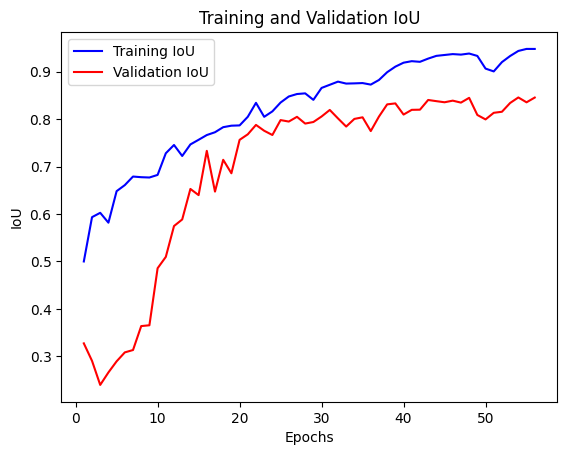

In [25]:
train_iou=history.history['binary_io_u']
val_iou=history.history['val_binary_io_u']
epochs=range(1,len(train_iou)+1)
plt.plot(epochs,train_iou,'b',label='Training IoU')
plt.plot(epochs,val_iou,'r',label='Validation IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('IoU')

## **Loss**

Text(0, 0.5, 'Loss')

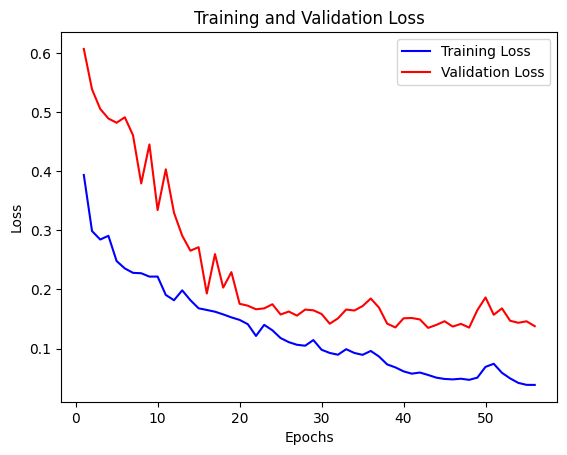

In [26]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(train_loss)+1)
plt.plot(epochs,train_loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

# **Accuracy**

Text(0.5, 0, 'Epochs')

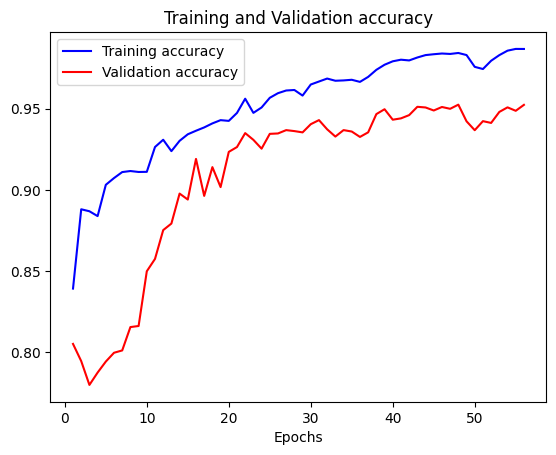

In [27]:
train_per=history.history['accuracy']
val_per=history.history['val_accuracy']
epochs=range(1,len(train_per)+1)
plt.plot(epochs,train_per,'b',label='Training accuracy')
plt.plot(epochs,val_per,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.xlabel('Epochs')

In [28]:
y_pred=model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [29]:
y_pred_binary = (y_pred > 0.5).astype(np.float32)

In [30]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score,classification_report,confusion_matrix

y_true_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()
print(y_true_flat.shape)
print(y_pred_flat.shape)

accuracy = accuracy_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}")

(393216,)
(393216,)
Accuracy: 0.9670, F1: 0.9490, IoU: 0.9029


In [31]:
print(classification_report(y_true_flat,y_pred_flat))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98    265215
         1.0       0.96      0.94      0.95    128001

    accuracy                           0.97    393216
   macro avg       0.96      0.96      0.96    393216
weighted avg       0.97      0.97      0.97    393216



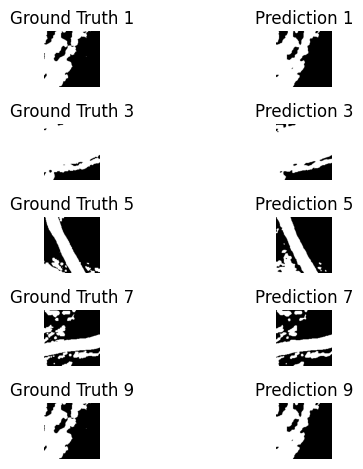

In [32]:
for i in range(0, 10, 2):
    idx = i // 2
    index=random.choice(range(len(x_test)))
    plt.subplot(5, 2, 2*idx + 1)
    plt.imshow(y_test[index], cmap='gray')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')

    plt.subplot(5, 2, 2*idx + 2)
    plt.imshow(y_pred_binary[index], cmap='gray')
    plt.title(f'Prediction {i+1}')
    plt.axis('off')

plt.tight_layout()  # Prevent overlapping
plt.show()

In [34]:
model.save("/content/drive/MyDrive/segmentation/model.h5")